/tmp/ipykernel_54292/1953113271.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed

TSLA prices loaded and cleaned.
Training data points: 2265
Testing data points: 271
Training data runs from 2015-07-01 to 2024-07-01
Testing data runs from 2024-07-01 to 2025-07-30


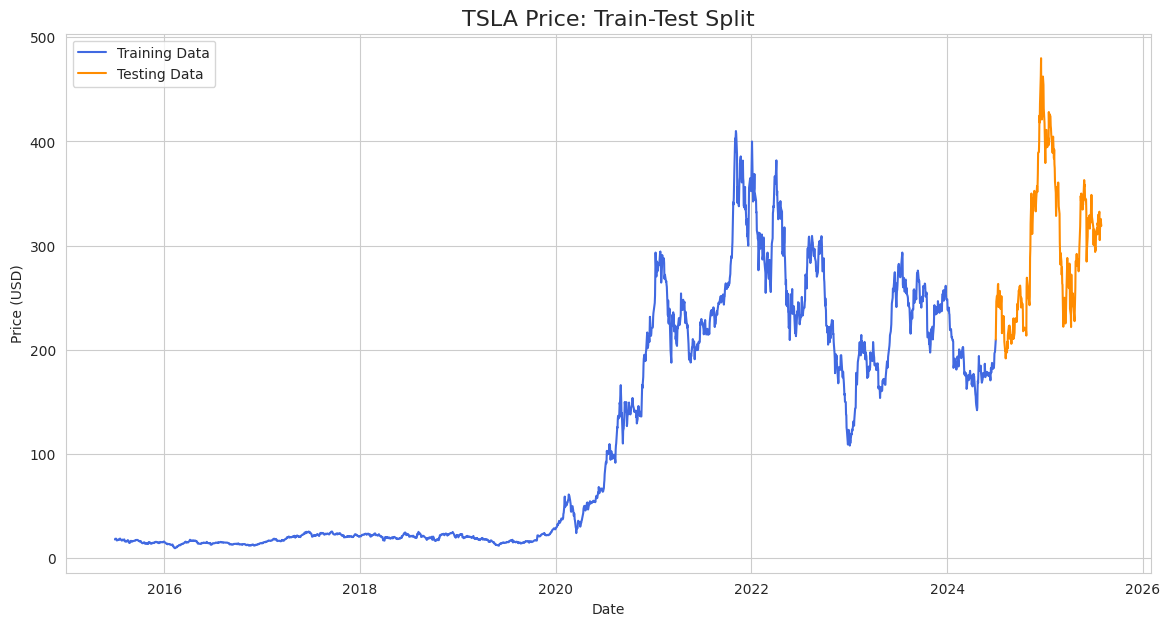

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---
# In a real project, you might save the cleaned data to a CSV and load it here.
# For simplicity, we'll quickly re-download and clean it.
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2025-07-31'

data = yf.download(tickers, start=start_date, end=end_date)
close_df = data['Close'].ffill()
tsla_prices = close_df['TSLA'].dropna()


# --- 2. Split the Data ---
# Define the split date
split_date = '2024-07-01'

# Create training and testing sets chronologically
train_data = tsla_prices[:split_date]
test_data = tsla_prices[split_date:]

# --- 3. Verify the Split ---
print(f"Training data points: {len(train_data)}")
print(f"Testing data points: {len(test_data)}")
print(f"Training data runs from {train_data.index.min().date()} to {train_data.index.max().date()}")
print(f"Testing data runs from {test_data.index.min().date()} to {test_data.index.max().date()}")

# Visualize the split
sns.set_style('whitegrid')
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data', color='royalblue')
plt.plot(test_data, label='Testing Data', color='darkorange')
plt.title('TSLA Price: Train-Test Split', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [19]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import pandas as pd

# --- 1. Prepare Data for statsforecast ---
# The library requires a DataFrame with specific column names:
# 'unique_id': An identifier for the time series.
# 'ds': The datestamp.
# 'y': The numerical value of the series.

# Convert our training data Series to the required format
train_df_sf = train_data.to_frame().reset_index()
train_df_sf.columns = ['ds', 'y']
train_df_sf['unique_id'] = 'TSLA' # Assign the identifier

print("--- Data prepared for statsforecast ---")
print(train_df_sf.head())


# --- 2. Define and Configure the Model ---
# We'll use AutoARIMA, which automatically finds the best SARIMA order.
# We instruct it to check for a yearly seasonal cycle.
models = [AutoARIMA(season_length=252)]


# --- 3. Instantiate and Train the Forecaster ---
# The StatsForecast object orchestrates the training process.
sf = StatsForecast(
    models=models,
    freq='B',       # 'B' for Business day frequency, which fits stock data
    n_jobs=-1       # Use all available CPU cores to speed up the process
)

print("\nTraining the AutoARIMA model... 🚀")
sf.fit(train_df_sf)
print("✅ Model training complete!")

--- Data prepared for statsforecast ---
          ds          y unique_id
0 2015-07-01  17.943333      TSLA
1 2015-07-02  18.667999      TSLA
2 2015-07-06  18.648001      TSLA
3 2015-07-07  17.858667      TSLA
4 2015-07-08  16.997334      TSLA

Training the AutoARIMA model... 🚀
✅ Model training complete!


In [20]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- Step 1: Preprocess Data for the LSTM ---

# 1a. Scale the Data
# Neural networks work best when input data is scaled to a small range, like 0 to 1.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

# 1b. Create Training Sequences
# We'll use the last 60 days of data to predict the 61st day.
sequence_length = 60
X_train = []
y_train = []

for i in range(sequence_length, len(scaled_train_data)):
    X_train.append(scaled_train_data[i-sequence_length:i, 0])
    y_train.append(scaled_train_data[i, 0])

# Convert to NumPy arrays for the model
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to be [samples, time_steps, features] for the LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Shape of training data for LSTM: {X_train.shape}")


# --- Step 2: Build the LSTM Model Architecture ---

model_lstm = Sequential()

# Layer 1: LSTM with 256 units
model_lstm.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2)) # Dropout for regularization

# Layer 2: LSTM with 256 units
model_lstm.add(LSTM(units=256, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Layer 3: Dense output layer
model_lstm.add(Dense(units=1))

print("\n--- LSTM Model Summary ---")
model_lstm.summary()


# --- Step 3: Compile and Train the Model ---

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# An epoch is one full pass through the entire training dataset.
# This may take a few minutes to run.
print("\nTraining the LSTM model...")
history = model_lstm.fit(X_train, y_train, epochs=128, batch_size=64)
print("✅ LSTM model training complete!")

Shape of training data for LSTM: (2205, 60, 1)

--- LSTM Model Summary ---


/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,761 (3.01 MB)

 Trainable params: 789,761 (3.01 MB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model...
Epoch 1/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0077
Epoch 2/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0013
Epoch 3/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0013
Epoch 4/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0010
Epoch 5/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0013
Epoch 6/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0011  
Epoch 7/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 9.2602e-04
Epoch 8/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 9.2349e-04
Epoch 9/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 9.0458e-04
Epoch 10/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 8.9841e-04
Epoch 11/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 8.6401e-04
Epoch 12/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 8.6295e-04
Epoch 13/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 8.9743e-04
Epoch 14/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 8.7139

Generating AutoARIMA forecast... 🔮
Generating LSTM forecast iteratively... 🧠

--- Model Performance Metrics ---
AutoARIMA -> MAE: $87.81 | RMSE: $109.87 | MAPE: 26.15%
LSTM ->      MAE: $98.92 | RMSE: $120.41 | MAPE: 29.84%


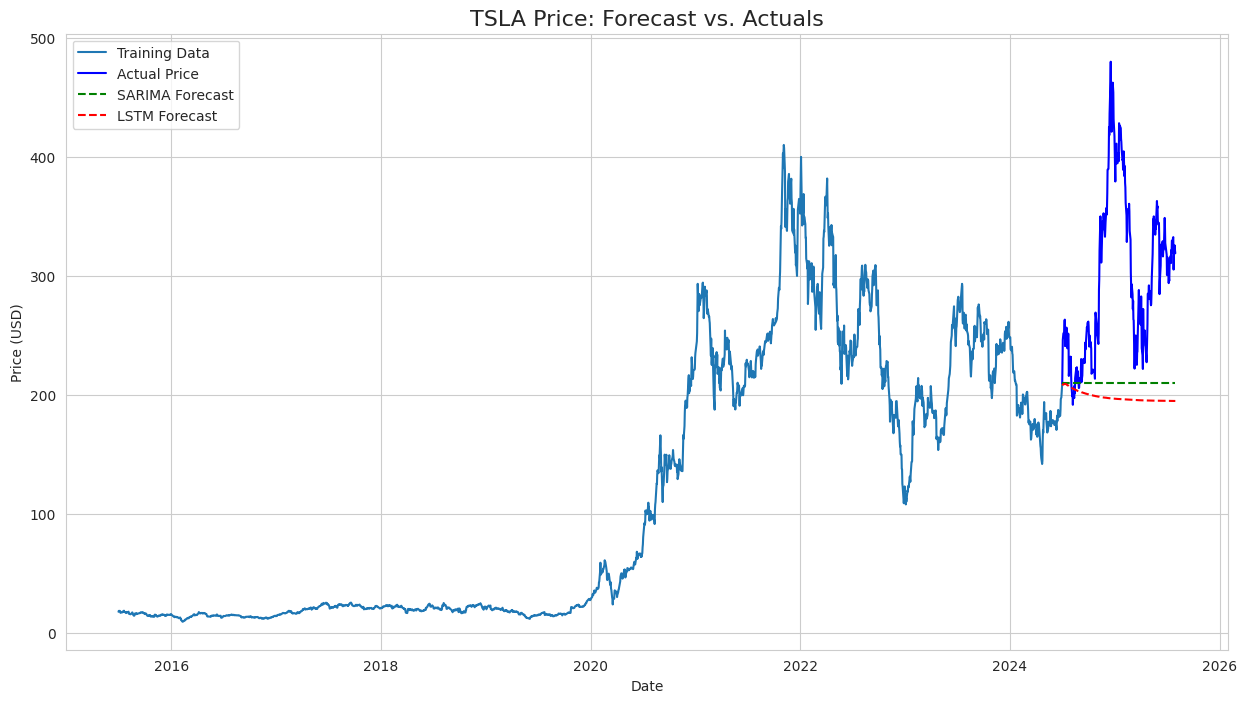

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Generate SARIMA Forecast (No changes here) ---
print("Generating AutoARIMA forecast... 🔮")
sarima_forecast_df = sf.predict(h=len(test_data))
sarima_predictions = sarima_forecast_df['AutoARIMA']


# --- 2. Generate LSTM Forecast (Corrected) ---
last_sequence = scaled_train_data[-sequence_length:]
lstm_predictions_scaled = []
current_sequence = last_sequence.reshape(1, sequence_length, 1)

print("Generating LSTM forecast iteratively... 🧠")
for i in range(len(test_data)):
    next_prediction = model_lstm.predict(current_sequence, verbose=0)
    lstm_predictions_scaled.append(next_prediction[0, 0])
    
    # --- THIS IS THE CORRECTED LINE ---
    # Reshape the prediction to (1, 1, 1) before appending
    new_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_sequence = np.append(current_sequence[:, 1:, :], new_prediction_reshaped, axis=1)
    # --- END OF CORRECTION ---

lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions_scaled).reshape(-1, 1)).flatten()


# --- 3. Compare Models and Evaluate Performance (No changes here) ---
sarima_predictions = pd.Series(sarima_predictions.values, index=test_data.index)
lstm_predictions = pd.Series(lstm_predictions, index=test_data.index)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n--- Model Performance Metrics ---")
mae_sarima = mean_absolute_error(test_data, sarima_predictions)
rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_predictions))
mape_sarima = mean_absolute_percentage_error(test_data, sarima_predictions)
print(f"AutoARIMA -> MAE: ${mae_sarima:.2f} | RMSE: ${rmse_sarima:.2f} | MAPE: {mape_sarima:.2f}%")

mae_lstm = mean_absolute_error(test_data, lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(test_data, lstm_predictions))
mape_lstm = mean_absolute_percentage_error(test_data, lstm_predictions)
print(f"LSTM ->      MAE: ${mae_lstm:.2f} | RMSE: ${rmse_lstm:.2f} | MAPE: {mape_lstm:.2f}%")

plt.figure(figsize=(15, 8))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Price')
plt.plot(sarima_predictions, color='green', linestyle='--', label='SARIMA Forecast')
plt.plot(lstm_predictions, color='red', linestyle='--', label='LSTM Forecast')
plt.title('TSLA Price: Forecast vs. Actuals', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.show()